In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler


In [2]:
# Load Data
data = pd.read_csv('DataImpurityGAN.csv')
# Drop First Column
data = data.drop(columns='Primary ID')

In [3]:
# Drop NAN
data = data.dropna()

In [4]:
# Here we split the two classes into different dataframes

# Group the data by the "Class" column
grouped_data = data.groupby('Class')

# Create an empty dictionary to store the DataFrames
dfs = {}

# Iterate over each group and store the data in the dictionary
for class_, group in grouped_data:
    dfs[class_] = group.copy()

# Access the separate DataFrames
df_class_1 = dfs[1]
df_class_2 = dfs[2]


DataFrame for Class 1:
      x1:Primary Column Reflux Flow  x2:Primary Column Tails Flow  \
5047                     263.622986                     49.571701   
6353                     364.282990                     50.604801   
6354                     361.723999                     50.358898   
6355                     364.295990                     50.621101   
6356                     363.878998                     50.298401   
...                             ...                           ...   
9072                     387.972992                     48.541401   
9073                     390.028015                     48.459099   
9075                     394.520996                     48.471100   
9078                     414.657990                     48.508301   
9079                     413.001007                     48.526600   

      x3:Input to Primary Column Bed 3 Flow  \
5047                            2375.280029   
6353                            3197.459961   
6354   

In [5]:
# Now that we have two different dataframes we can drop class column
df_class_1 = df_class_1.drop(columns= 'Class')
df_class_2 = df_class_2.drop(columns= 'Class')

In [6]:
df_class_1.shape, df_class_2.shape

((2720, 45), (7085, 45))

In [7]:
# Column Names saved for later when we remake DataFrames
column_names = df_class_2.columns
# column_names

Index(['x1:Primary Column Reflux Flow', 'x2:Primary Column Tails Flow',
       'x3:Input to Primary Column Bed 3 Flow',
       'x4:Input to Primary Column Bed 2 Flow',
       'x5:Primary Column Feed Flow from Feed Column',
       'x6:Primary Column Make Flow', 'x7:Primary Column Base Level',
       'x8:Primary Column Reflux Drum Pressure',
       'x9:Primary Column Condenser Reflux Drum Level',
       'x10:Primary Column Bed1 DP', 'x11:Primary Column Bed2 DP',
       'x12:Primary Column Bed3 DP', 'x13:Primary Column Bed4 DP',
       'x14:Primary Column Base Pressure', 'x15:Primary Column Head Pressure',
       'x16:Primary Column Tails Temperature',
       'x17:Primary Column Tails Temperature 1',
       'x18:Primary Column Bed 4 Temperature',
       'x19:Primary Column Bed 3 Temperature',
       'x20:Primary Column Bed 2 Temperature',
       'x21:Primary Column Bed 1 Temperature',
       'x22: Secondary Column Base Concentration',
       'x23: Flow from Input to Secondary Column',
   

In [8]:
# Here we Scale the data
# Create an instance of StandardScaler
scaler1 = StandardScaler()
scaler2 = StandardScaler()

# Fit the scaler to data
scaler1.fit(df_class_2)
scaler2.fit(df_class_2)

# Transform the data to Standard scale
target_1 = scaler1.transform(df_class_1)
target_2 = scaler2.transform(df_class_2)
target_2.shape, target_1.shape

((7085, 45), (2720, 45))

In [9]:
# Specify length of training data first we train the class 2 since it has more data
num_data = 5000
target_2 = pd.DataFrame(target_2, columns = column_names).iloc[:num_data]
target_2.shape

(5000, 45)

# Parameters

In [10]:
# Input size and output size specify the shape of the tensor fed into the NN
# input and output correspond to the number of features
input_size = len(df_class_2.columns) 
output_size= len(df_class_2.columns)
# The size of the hidden layers within the transformer. This is also the size of the output from the embedding layer
# must be even number
hidden_size = len(df_class_2.columns)+1

# length of the input sequence, which is the number of historical data points that will be used to predict futere timesteps
seq_length = 10 

# sequence of future data that the model should try to predict
output_steps = 10

# Number of layers in the transformer to stack
num_layers = 5
# Number of heads in the multi-head attention mechanism of the transformer ( hidden_size must be divisible by num_heads)
num_heads = 2
# The dropout rate, a regularization technique
dropout = 0.1
# batch size is the size of data used in training
batch_size = 32


In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, output_steps):
        # Transform data to tensors
        self.data = torch.tensor(data.values, dtype=torch.float32)
        # Past time steps
        self.seq_length = seq_length
        # Future time steps
        self.output_steps = output_steps

    def __len__(self):
        return len(self.data) - self.seq_length - self.output_steps + 1

    def __getitem__(self, index):
        # Returns two tensors one for historical data and the other for future data to predict
        return (self.data[index:index+self.seq_length],
                self.data[index+self.seq_length:index+self.seq_length+self.output_steps])

In [12]:
# instantiate the dataset and dataloader
dataset = TimeSeriesDataset(target_2, seq_length, output_steps)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [13]:
class Transformer(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size, num_heads, dropout, seq_length, n_output_steps):
        super(Transformer, self).__init__()

        self.seq_length = seq_length
        self.n_output_steps = n_output_steps

        self.embedding = nn.Linear(input_size, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size, dropout)
        encoder_layer = nn.TransformerEncoderLayer(hidden_size, num_heads, hidden_size, dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

        self.init_weights()

    def init_weights(self):
        init_range = 0.1
        self.embedding.weight.data.uniform_(-init_range, init_range)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-init_range, init_range)

    def forward(self, input):
        batch_size = input.size(0)
        input = self.embedding(input)  # Embedding
        input = self.pos_encoder(input)  # Positional encoding
        output = self.encoder(input)  # Encoding
        output = self.decoder(output)  # Linear layer
        return output
    
# Define the positional encoding module Allows the transformer to know the unique position of the data
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # Here we make a matrix of the input data with each having a unique position
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [14]:
# Instantiate the model
model = Transformer(input_size, output_size, num_layers, hidden_size, num_heads, dropout, seq_length, output_steps)

# Loss and optimizer
criterion = nn.MSELoss()  # Change this if necessary
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Change this if necessary

In [15]:
# Training loop
num_epochs = 200  # Change this if necessary
model.train()  # Set the model to training mode
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(dataloader):
        # Move data to the correct device
        inputs = inputs
        targets = targets
#         print("Shape of inputs:", inputs.shape)
#         print("Shape of targets:", targets.shape)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:  # Print loss every 100 batches
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')

Epoch [1/200], Step [100/156], Loss: 0.4075
Epoch [2/200], Step [100/156], Loss: 0.2156
Epoch [3/200], Step [100/156], Loss: 0.1823
Epoch [4/200], Step [100/156], Loss: 0.1694
Epoch [5/200], Step [100/156], Loss: 0.1605
Epoch [6/200], Step [100/156], Loss: 0.1503
Epoch [7/200], Step [100/156], Loss: 0.1437
Epoch [8/200], Step [100/156], Loss: 0.1380
Epoch [9/200], Step [100/156], Loss: 0.1328
Epoch [10/200], Step [100/156], Loss: 0.1296
Epoch [11/200], Step [100/156], Loss: 0.1258
Epoch [12/200], Step [100/156], Loss: 0.1221
Epoch [13/200], Step [100/156], Loss: 0.1197
Epoch [14/200], Step [100/156], Loss: 0.1177
Epoch [15/200], Step [100/156], Loss: 0.1162
Epoch [16/200], Step [100/156], Loss: 0.1151
Epoch [17/200], Step [100/156], Loss: 0.1126
Epoch [18/200], Step [100/156], Loss: 0.1045
Epoch [19/200], Step [100/156], Loss: 0.1023
Epoch [20/200], Step [100/156], Loss: 0.0991
Epoch [21/200], Step [100/156], Loss: 0.0970
Epoch [22/200], Step [100/156], Loss: 0.0935
Epoch [23/200], Ste

Epoch [182/200], Step [100/156], Loss: 0.0547
Epoch [183/200], Step [100/156], Loss: 0.0540
Epoch [184/200], Step [100/156], Loss: 0.0532
Epoch [185/200], Step [100/156], Loss: 0.0538
Epoch [186/200], Step [100/156], Loss: 0.0542
Epoch [187/200], Step [100/156], Loss: 0.0538
Epoch [188/200], Step [100/156], Loss: 0.0537
Epoch [189/200], Step [100/156], Loss: 0.0532
Epoch [190/200], Step [100/156], Loss: 0.0525
Epoch [191/200], Step [100/156], Loss: 0.0526
Epoch [192/200], Step [100/156], Loss: 0.0538
Epoch [193/200], Step [100/156], Loss: 0.0520
Epoch [194/200], Step [100/156], Loss: 0.0524
Epoch [195/200], Step [100/156], Loss: 0.0533
Epoch [196/200], Step [100/156], Loss: 0.0533
Epoch [197/200], Step [100/156], Loss: 0.0540
Epoch [198/200], Step [100/156], Loss: 0.0523
Epoch [199/200], Step [100/156], Loss: 0.0533
Epoch [200/200], Step [100/156], Loss: 0.0517


In [16]:
def forecast(model, data, seq_length, output_steps):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Make sure data is a torch Tensor
    if not isinstance(data, torch.Tensor):
        data = torch.Tensor(data)
        
    # Number of forecasts
    num_forecasts = len(data) - seq_length
    
    # Container for predictions
    predictions = torch.zeros(num_forecasts, output_steps, data.shape[-1])
    
    # Slide over the time-series data
    for i in range(num_forecasts):
        # Get a sequence of data
        seq = data[i:i+seq_length]
        
        # Add an extra dimension for batch
        seq = seq.unsqueeze(0)
        
        # Compute the output
        with torch.no_grad():
            out = model(seq)
        
        # Save only the outputs for the last time step
        predictions[i] = out[0]
    
    return predictions


In [17]:
pred_data = pd.DataFrame(target_2, columns = column_names).iloc[3000:num_data]
pred_data.shape

(2000, 45)

In [18]:
input_data = torch.tensor(pred_data.values, dtype=torch.float32)

In [19]:
predictions = forecast(model, input_data, seq_length, output_steps)
predictions.shape

torch.Size([1990, 10, 45])

In [20]:
predictions

tensor([[[ 0.3480,  0.6153, -0.3607,  ..., -0.1950,  0.0132, -0.2113],
         [ 0.2741,  1.0109, -0.3126,  ..., -0.1795, -0.0699,  0.1231],
         [ 0.1894,  0.8180, -0.3548,  ..., -0.2312, -0.0758,  0.1213],
         ...,
         [ 0.2972,  1.0478, -0.3601,  ..., -0.1243, -0.0451,  0.1219],
         [ 0.2921,  0.9671, -0.2922,  ..., -0.2109,  0.0065,  0.0509],
         [ 0.3508,  1.1841, -0.3197,  ..., -0.1981, -0.0102,  0.0636]],

        [[ 0.2741,  1.0109, -0.3126,  ..., -0.1795, -0.0699,  0.1231],
         [ 0.1894,  0.8180, -0.3548,  ..., -0.2312, -0.0758,  0.1213],
         [ 0.2144,  1.0311, -0.3368,  ..., -0.1946, -0.0466,  0.1230],
         ...,
         [ 0.2921,  0.9671, -0.2922,  ..., -0.2109,  0.0065,  0.0509],
         [ 0.3508,  1.1841, -0.3197,  ..., -0.1981, -0.0102,  0.0636],
         [ 0.4046,  0.9595, -0.3011,  ..., -0.1771, -0.0272,  0.0724]],

        [[ 0.1894,  0.8180, -0.3548,  ..., -0.2312, -0.0758,  0.1213],
         [ 0.2144,  1.0311, -0.3368,  ..., -0

In [22]:
predictions= scaler2.inverse_transform(predictions[:, -1, :])

In [23]:
predictions.shape

(1990, 45)

In [24]:
test_data = pd.DataFrame(df_class_2, columns = column_names).iloc[num_data:]
test_data.shape

(2085, 45)

In [25]:
test_array_np = test_data.values

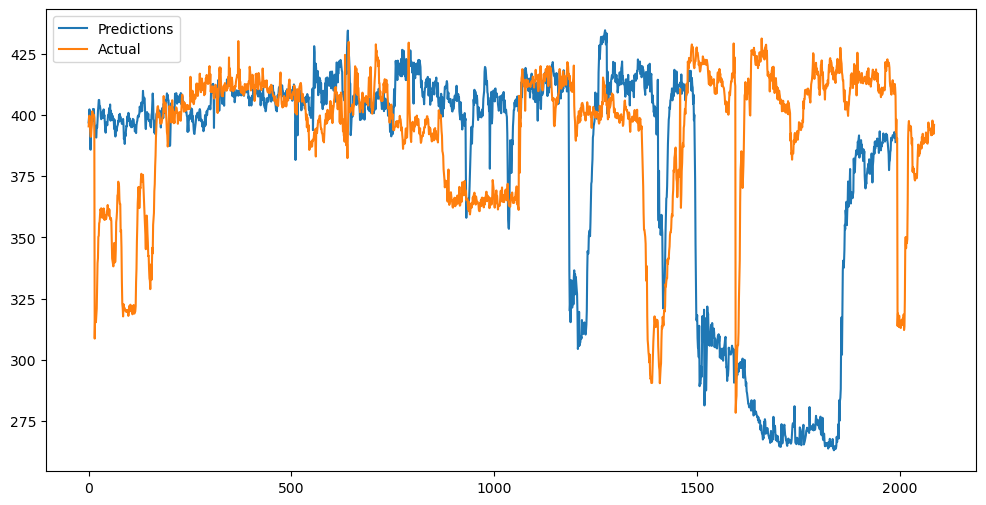

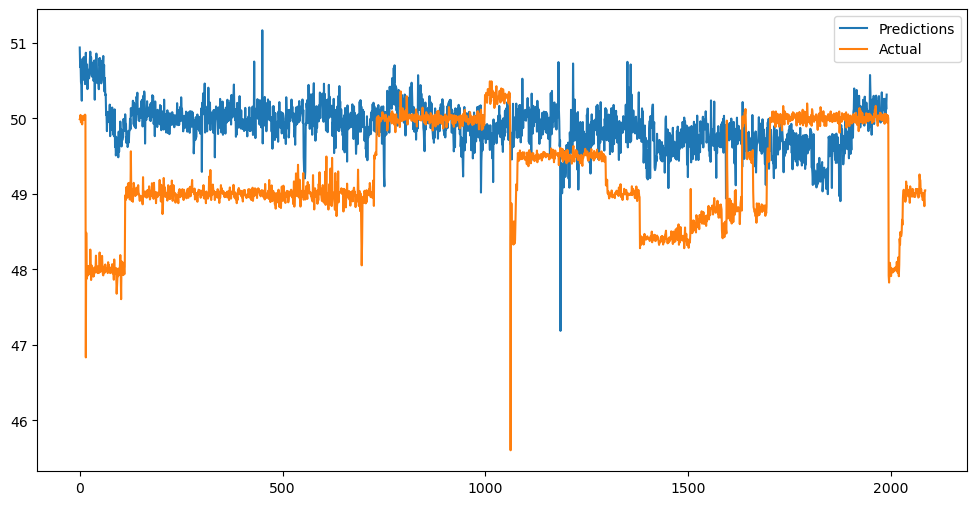

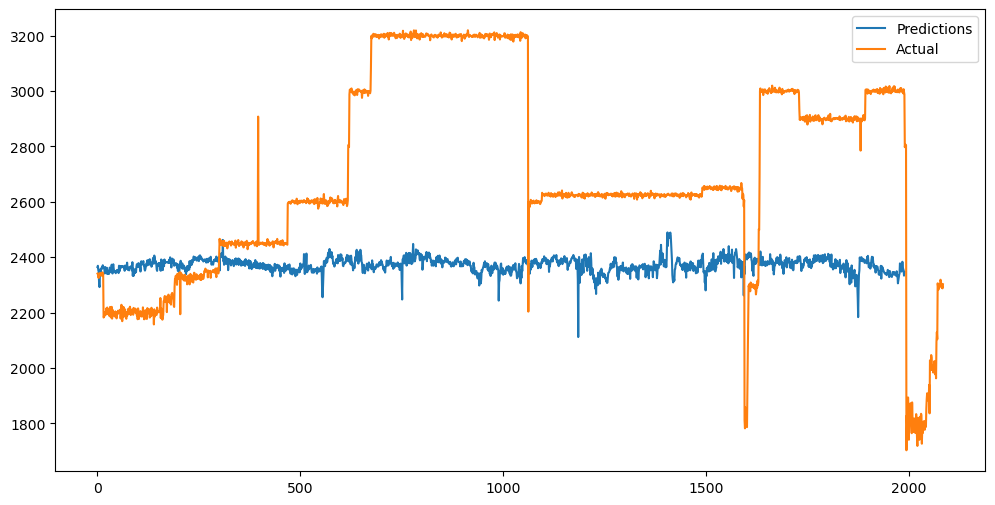

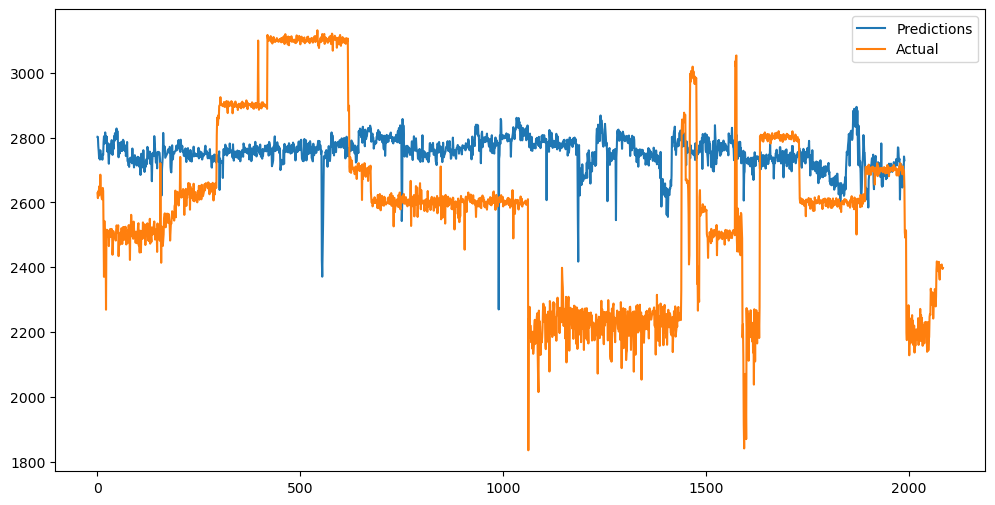

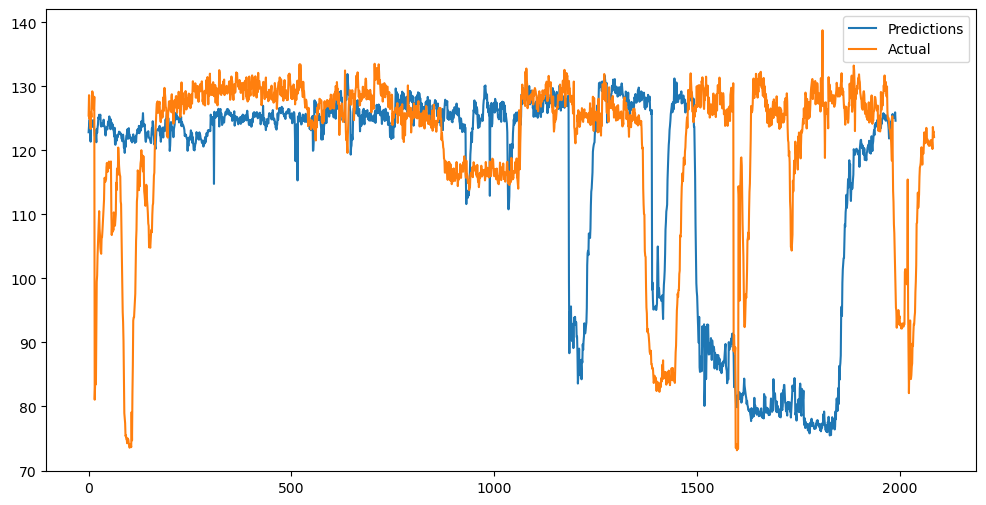

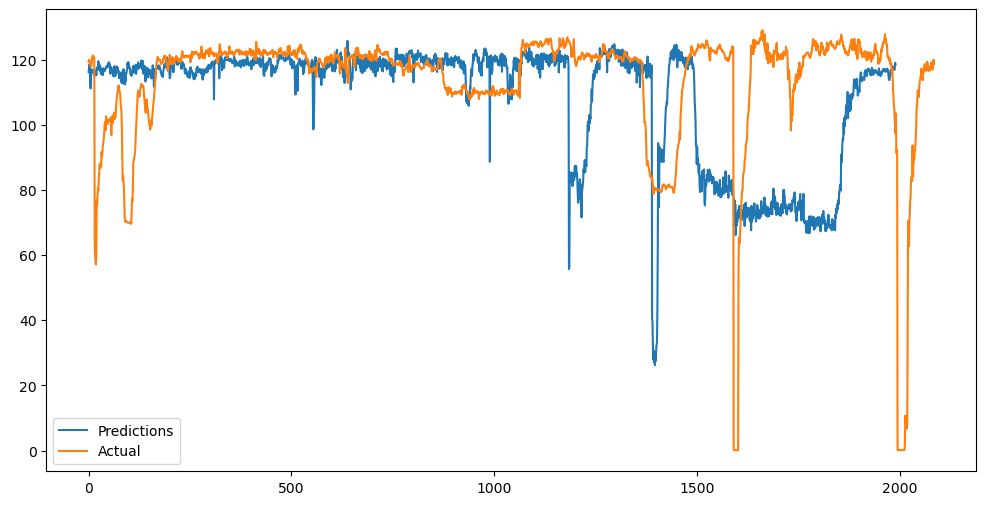

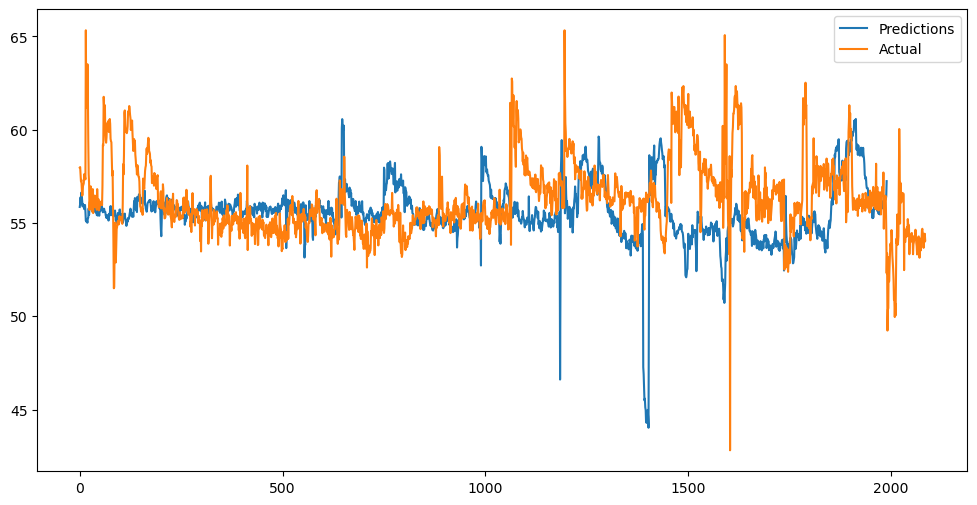

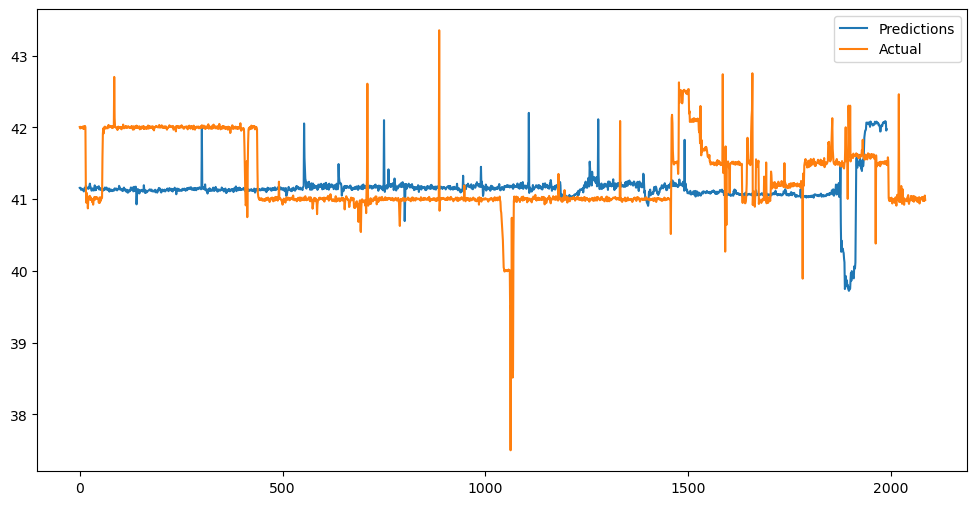

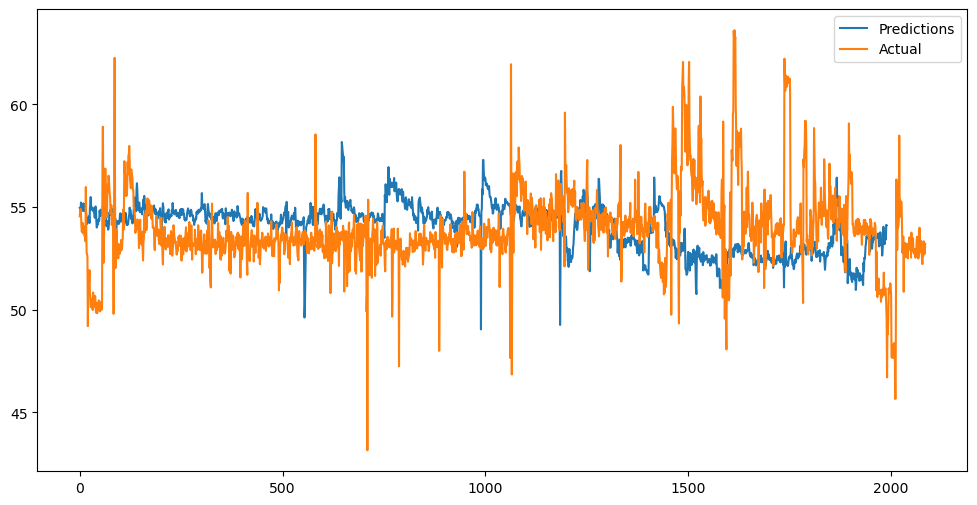

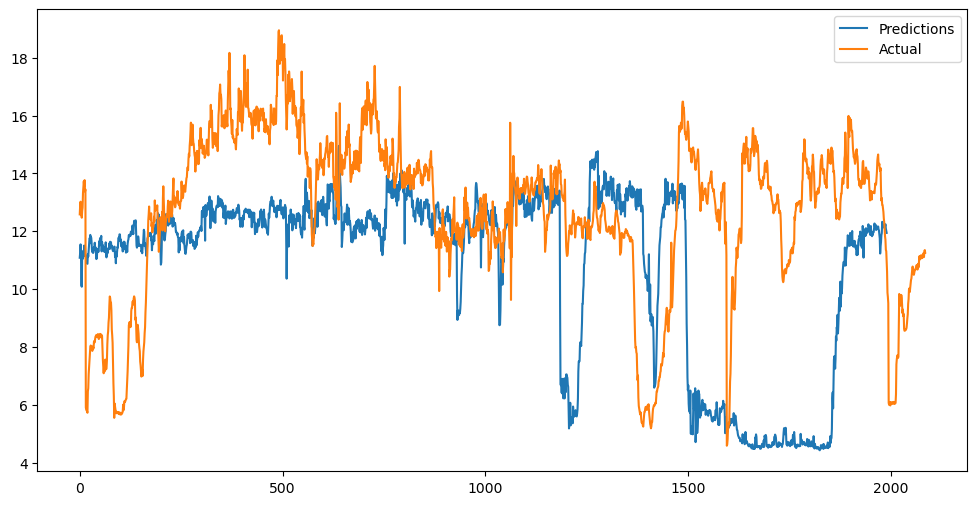

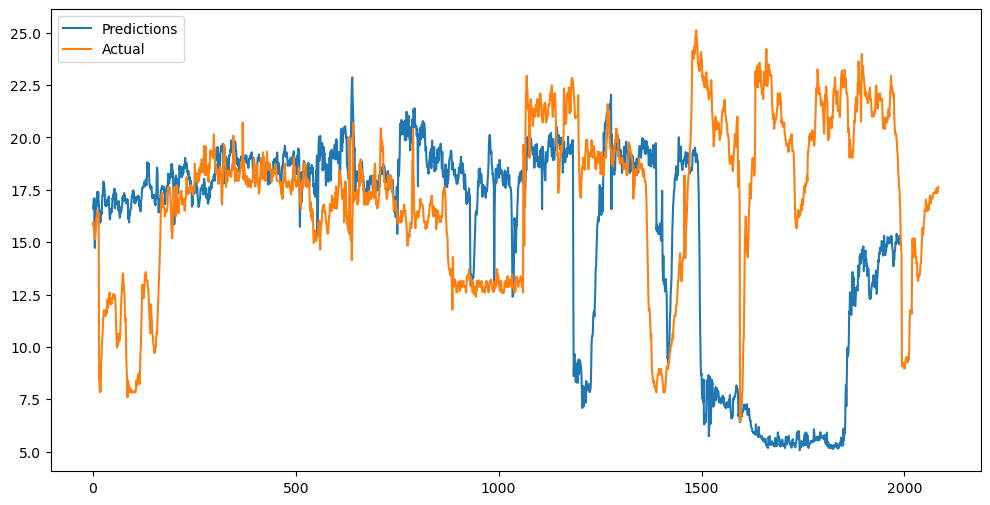

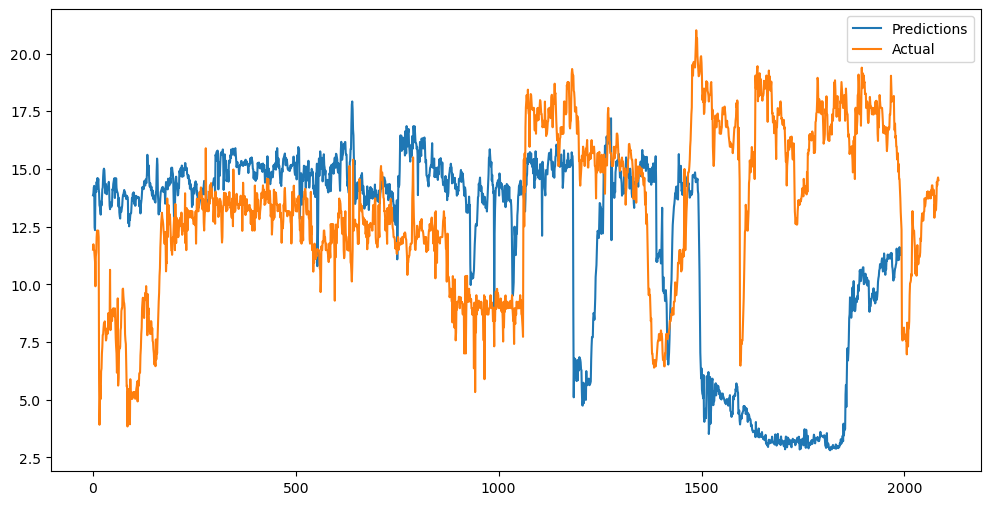

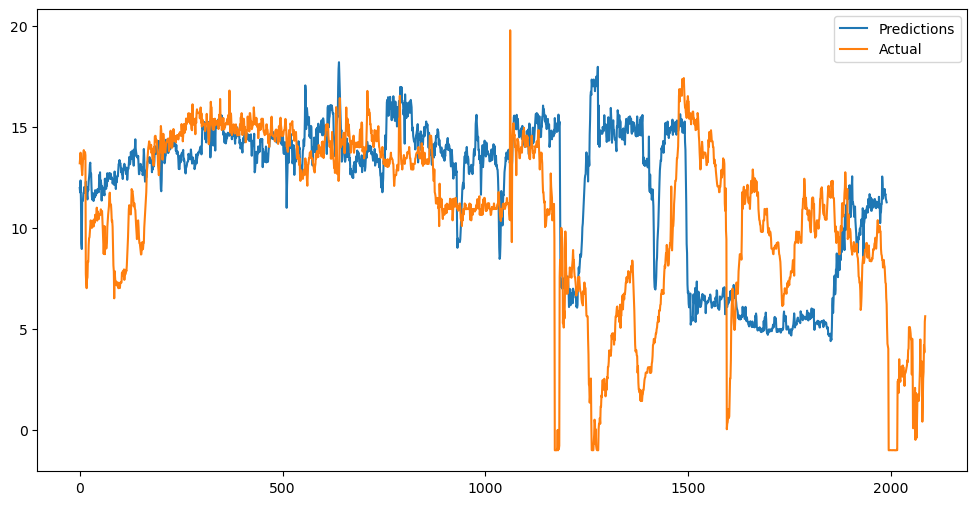

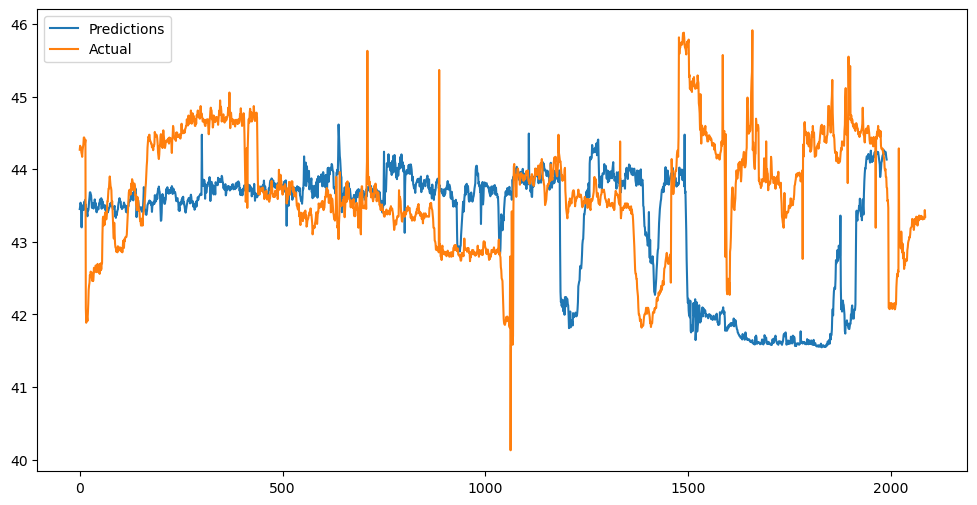

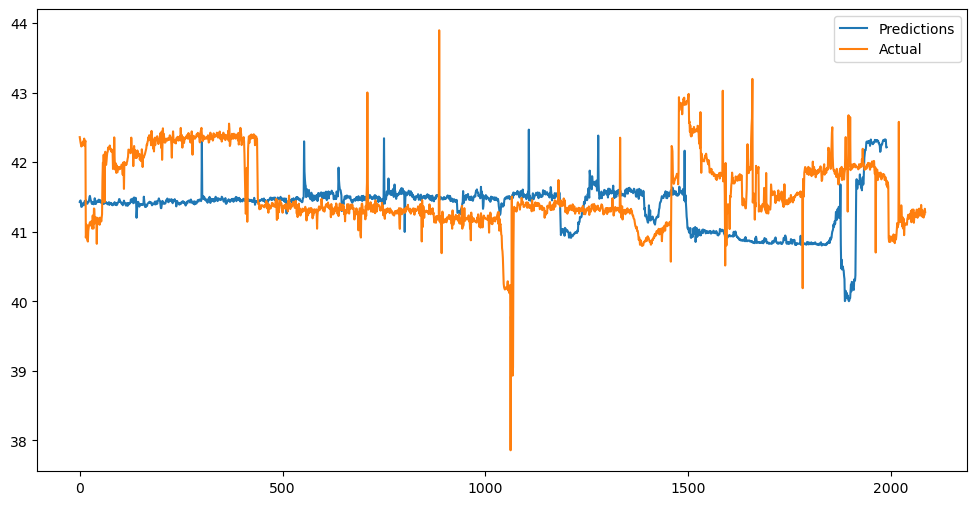

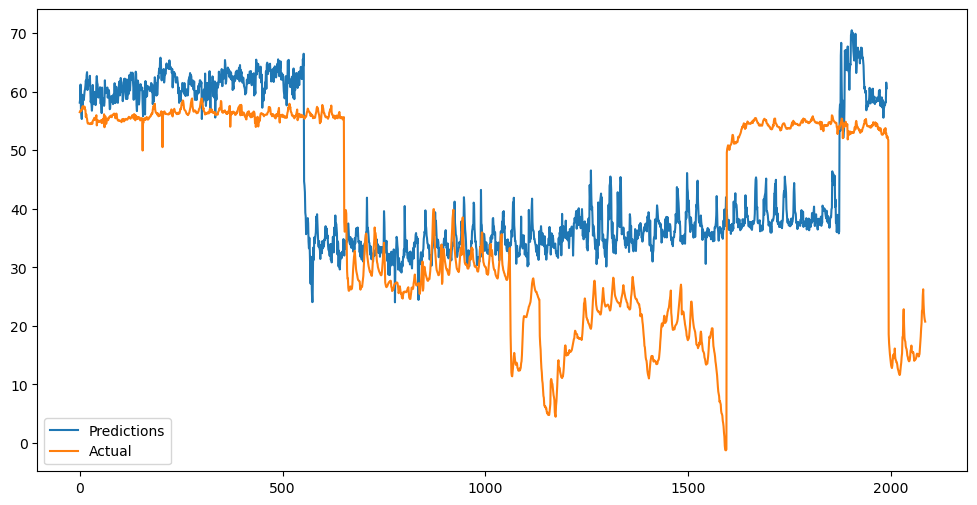

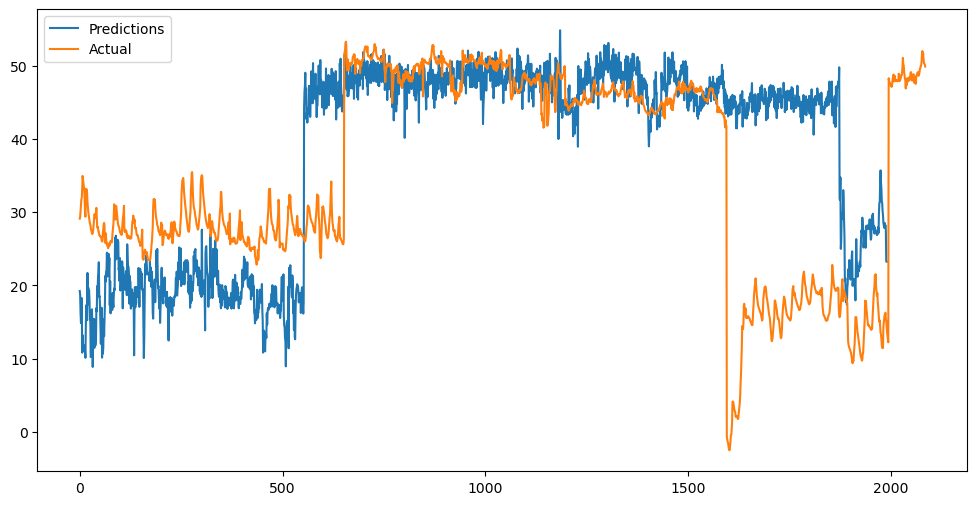

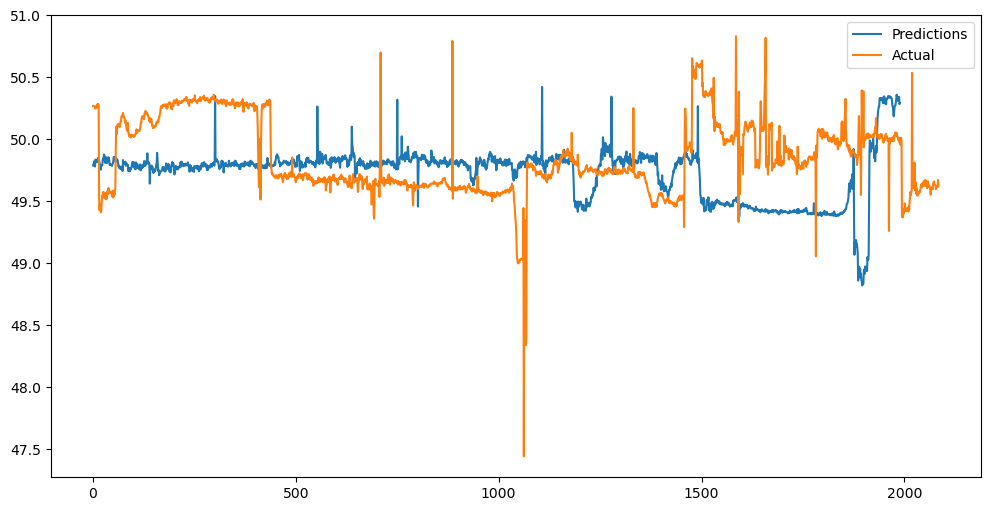

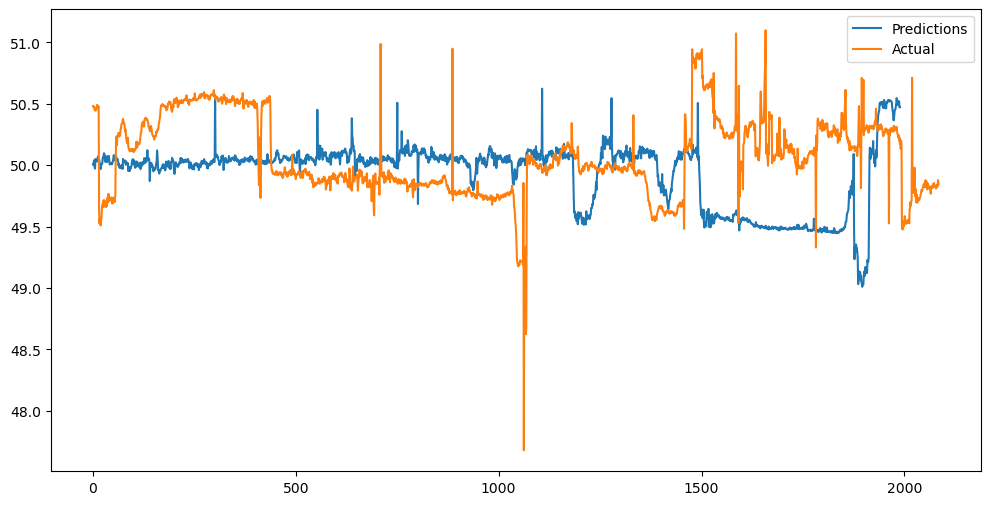

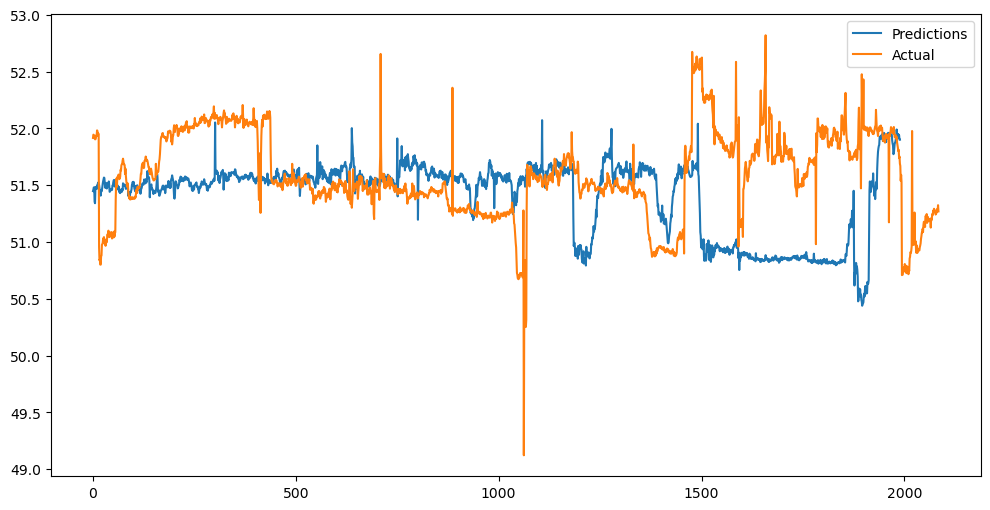

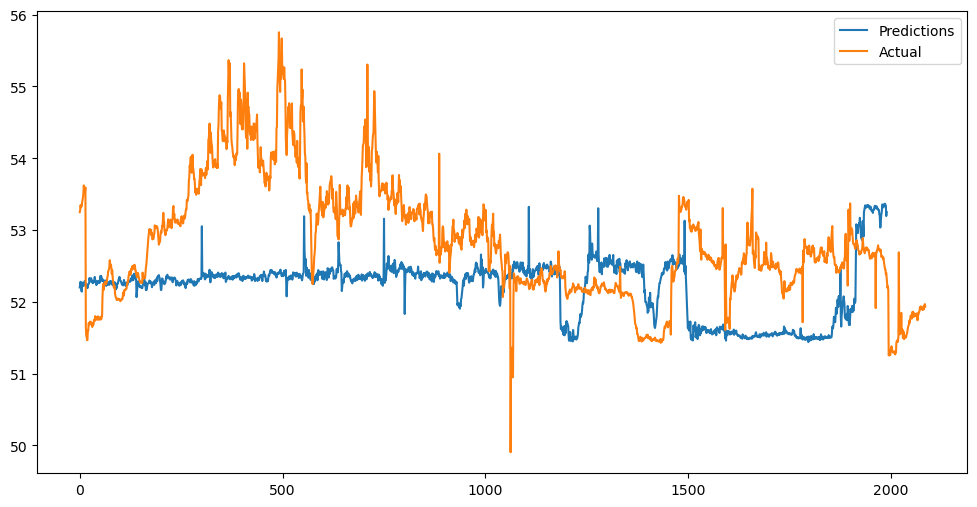

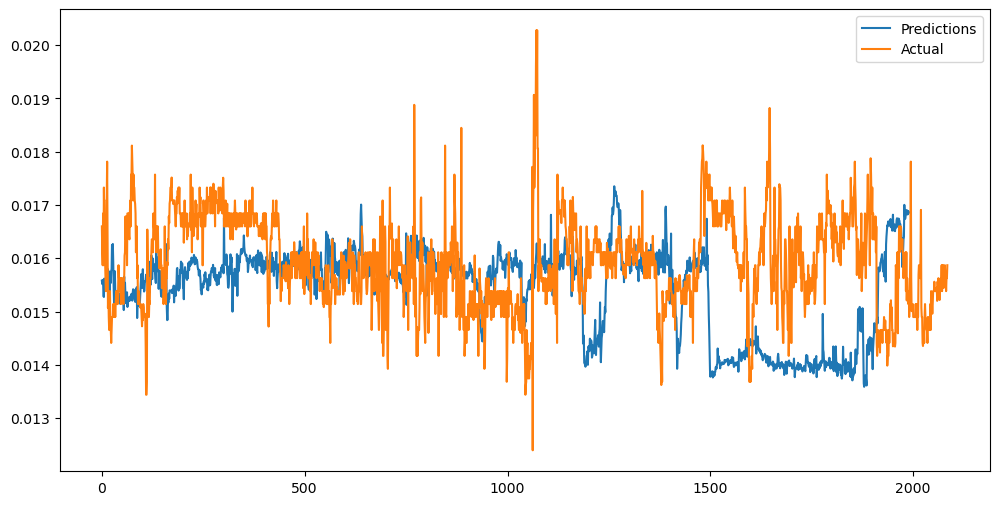

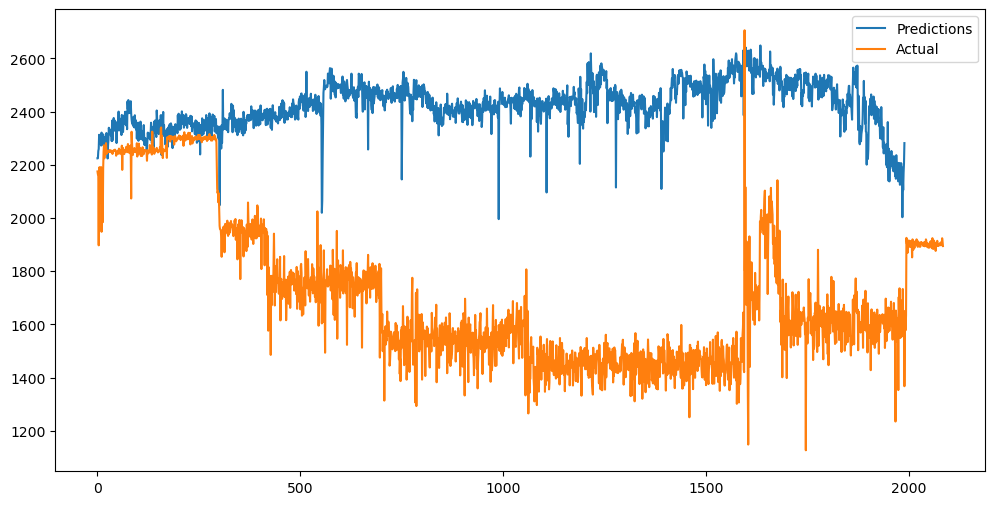

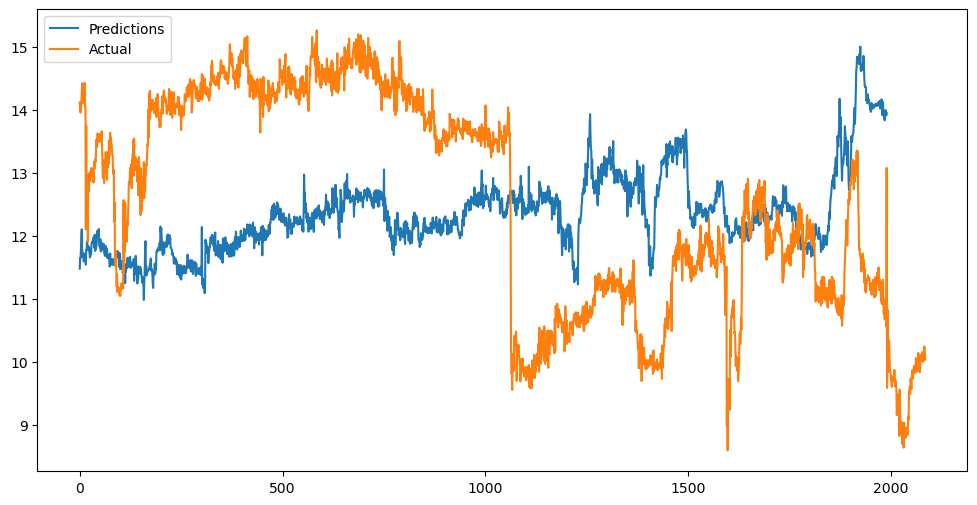

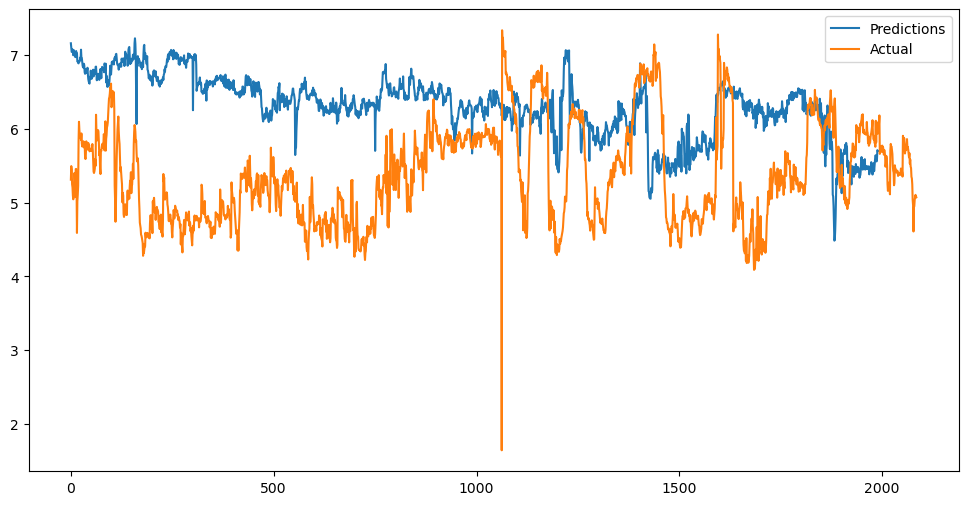

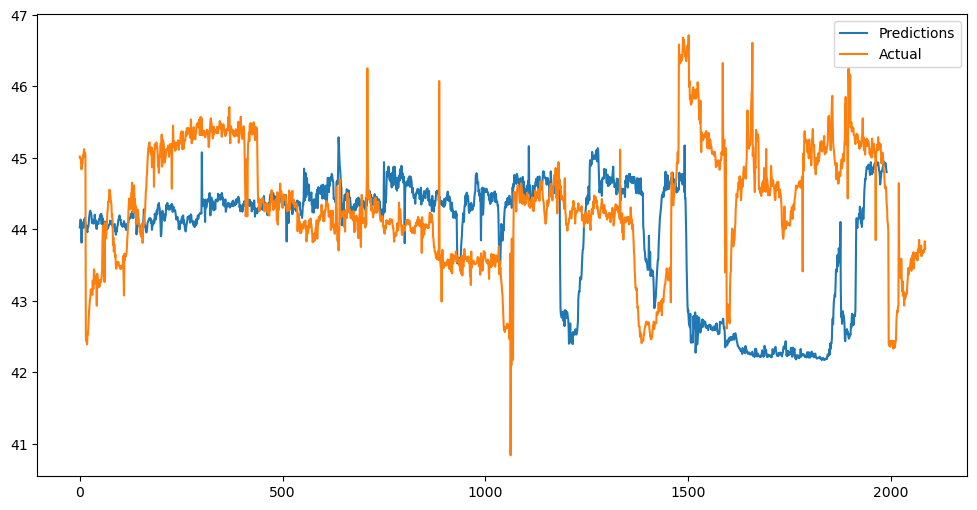

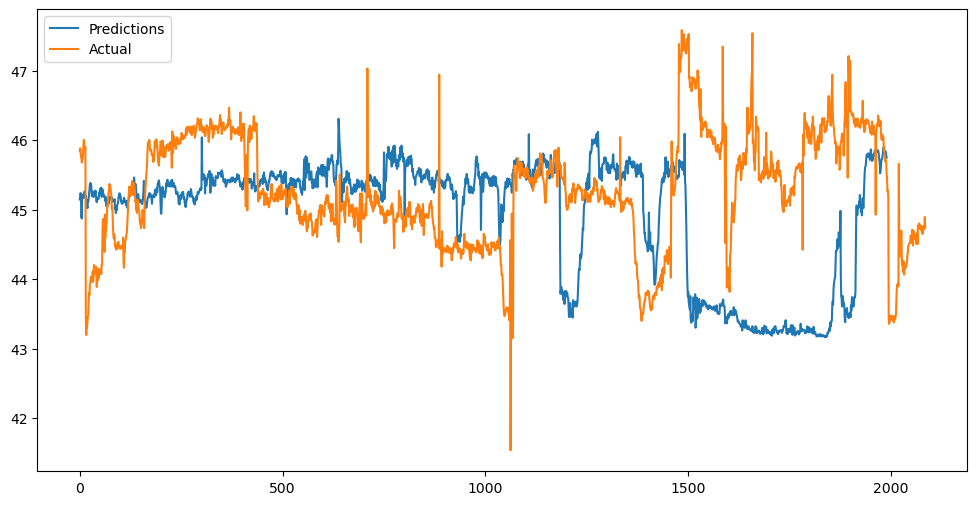

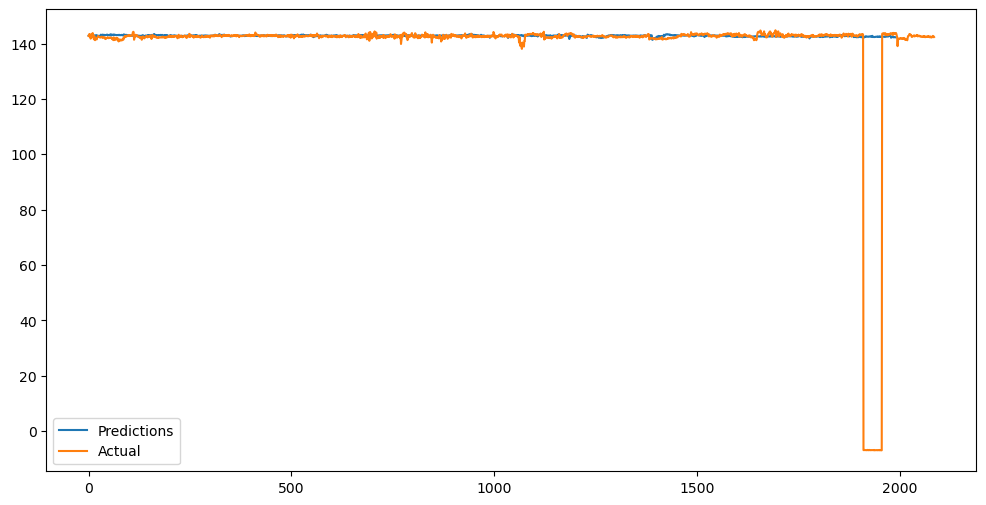

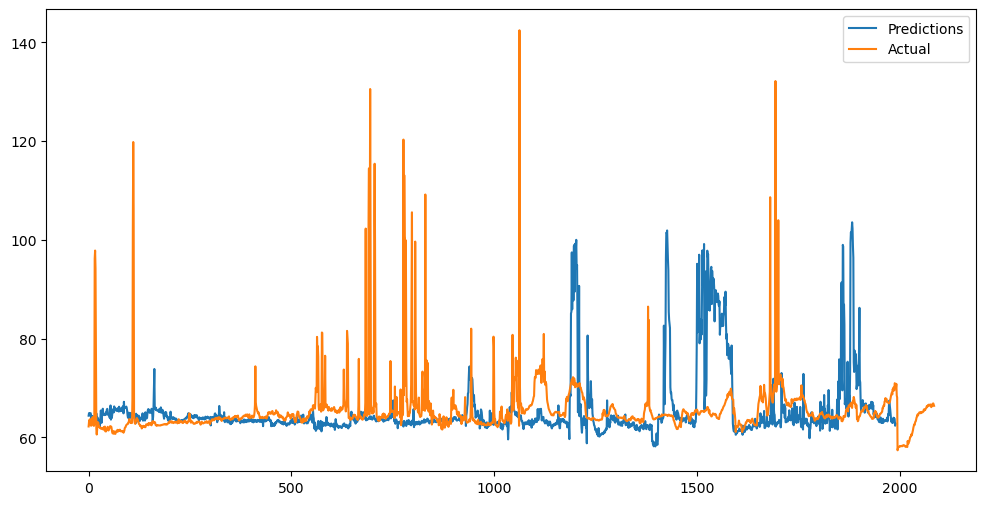

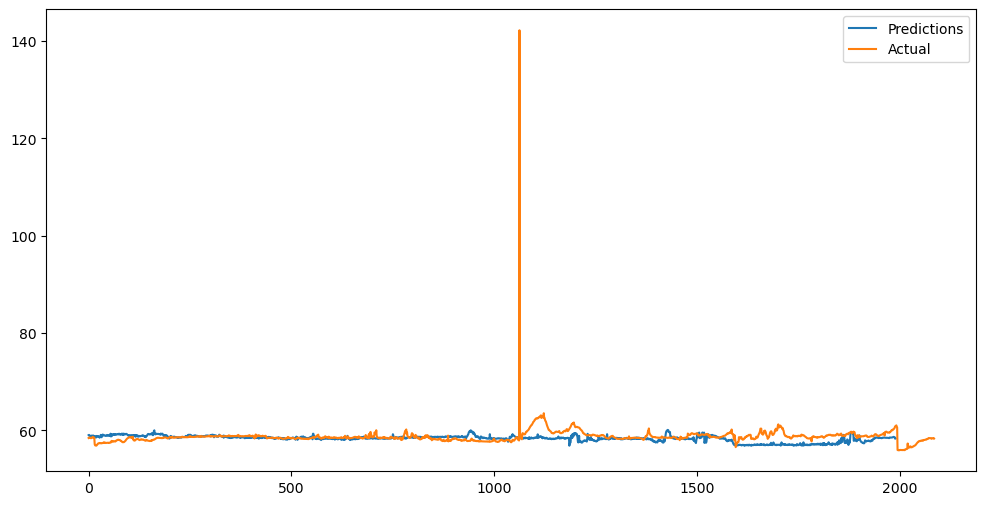

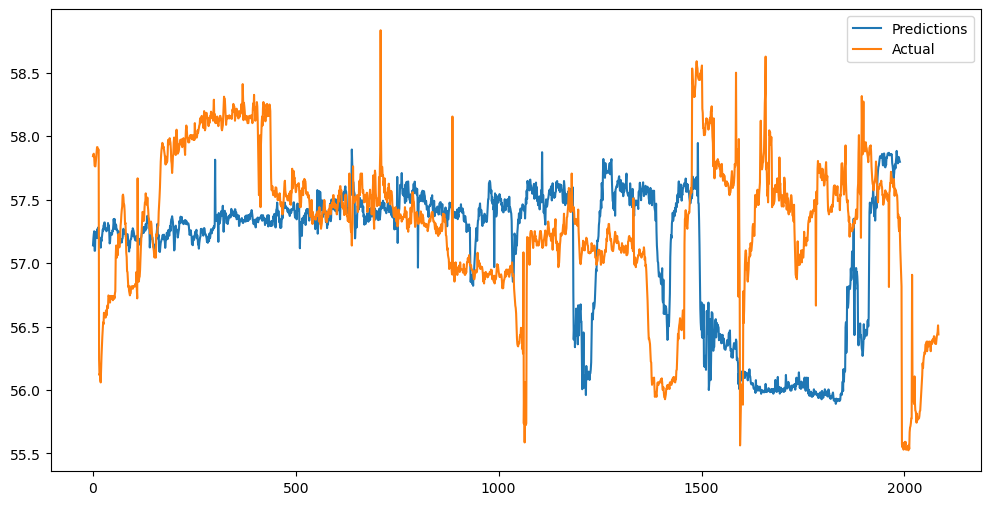

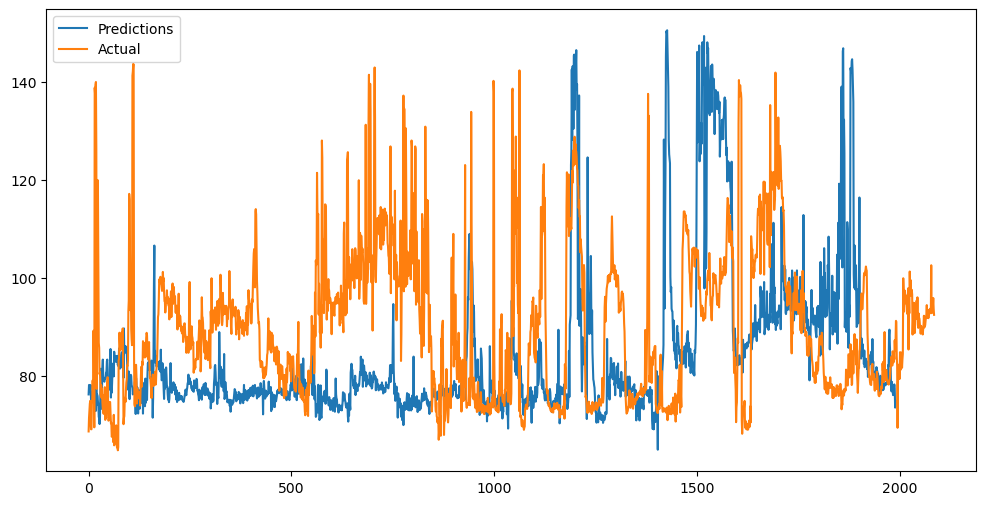

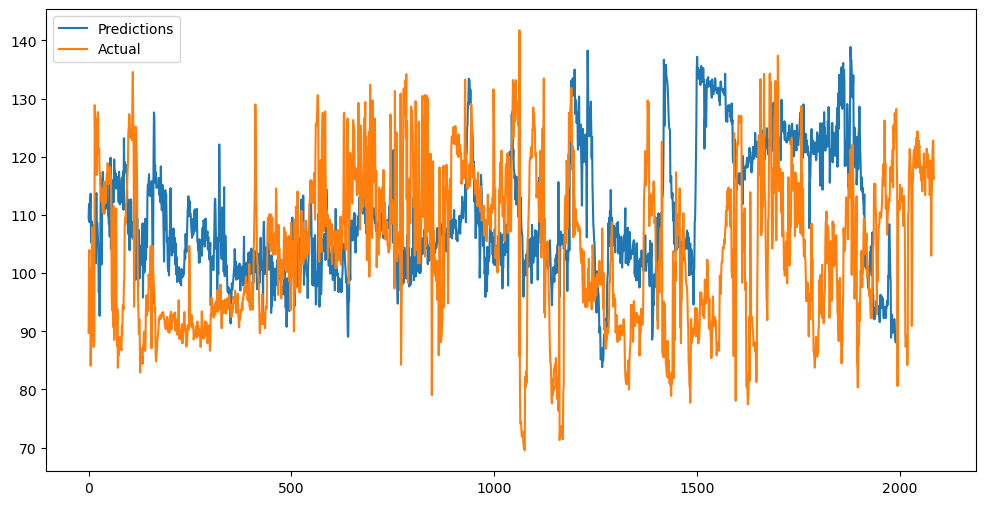

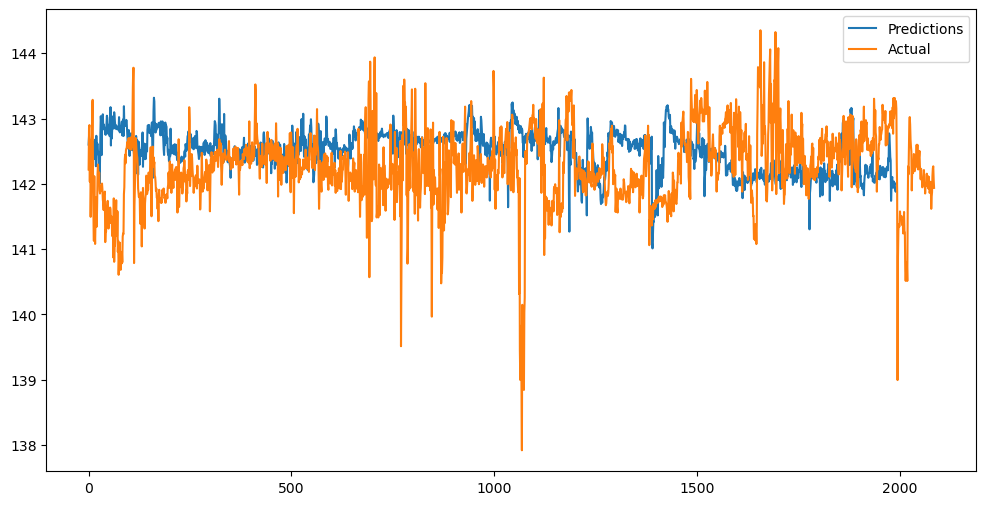

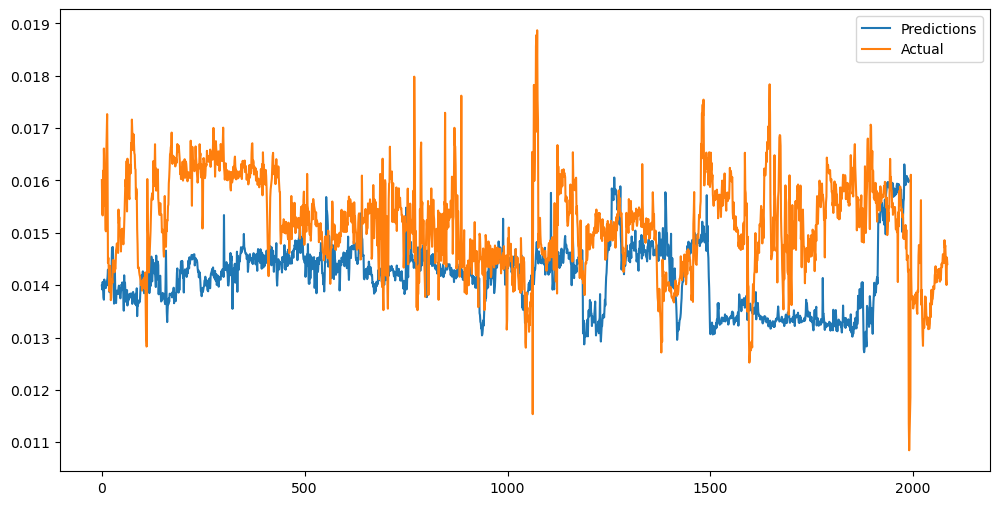

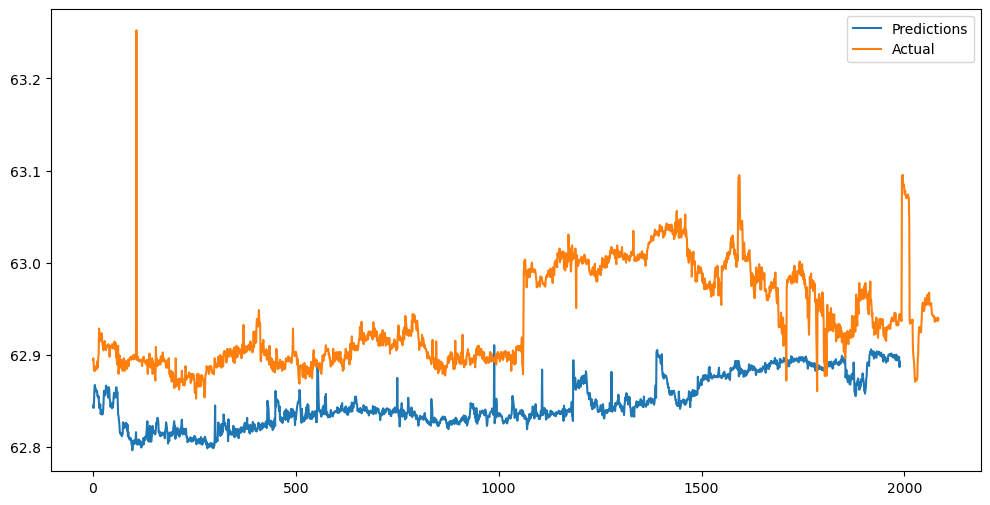

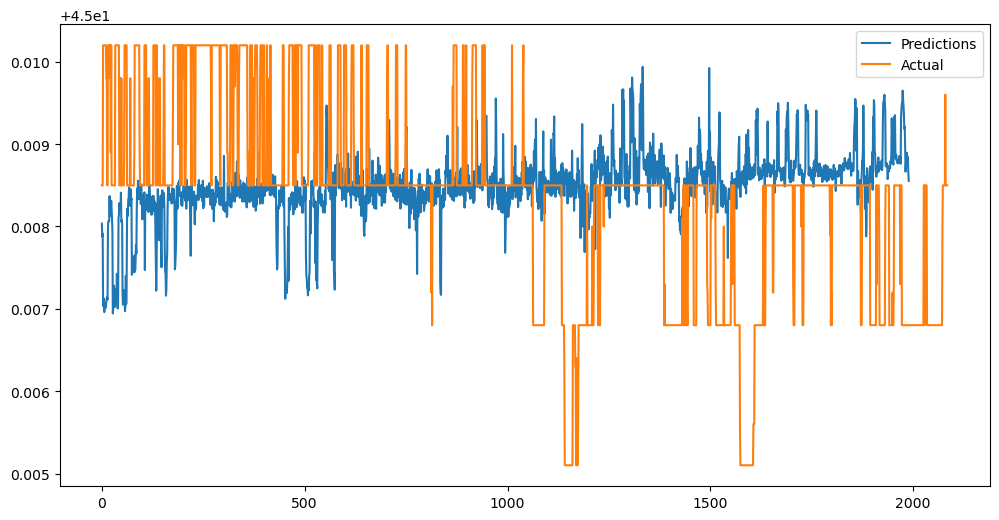

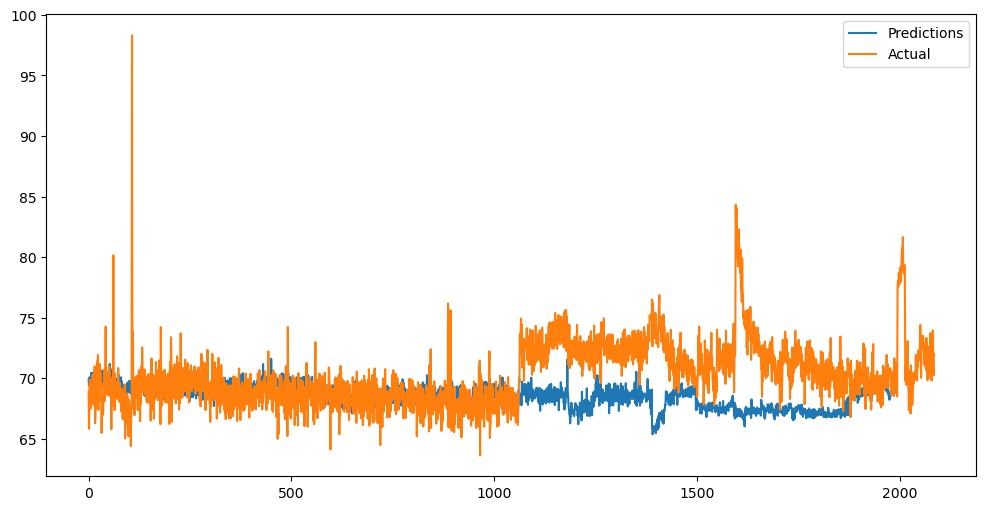

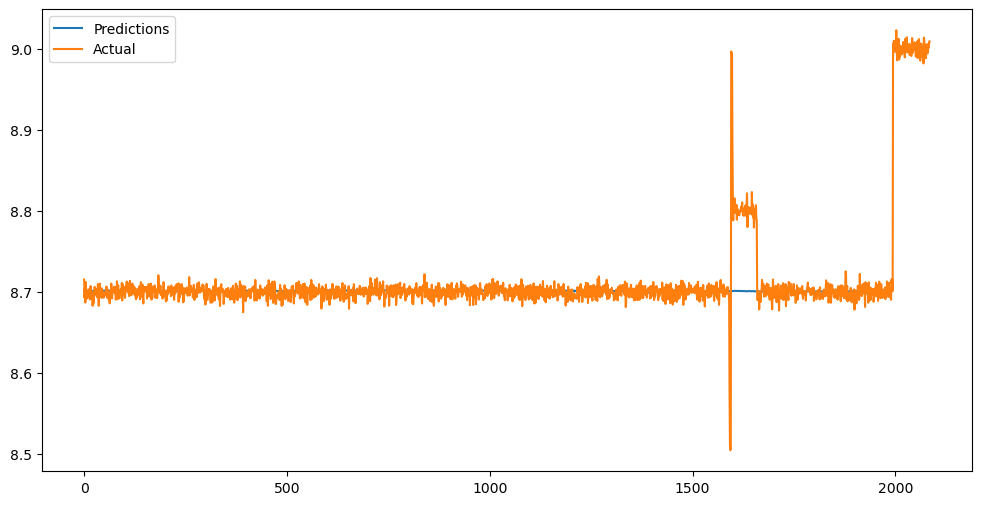

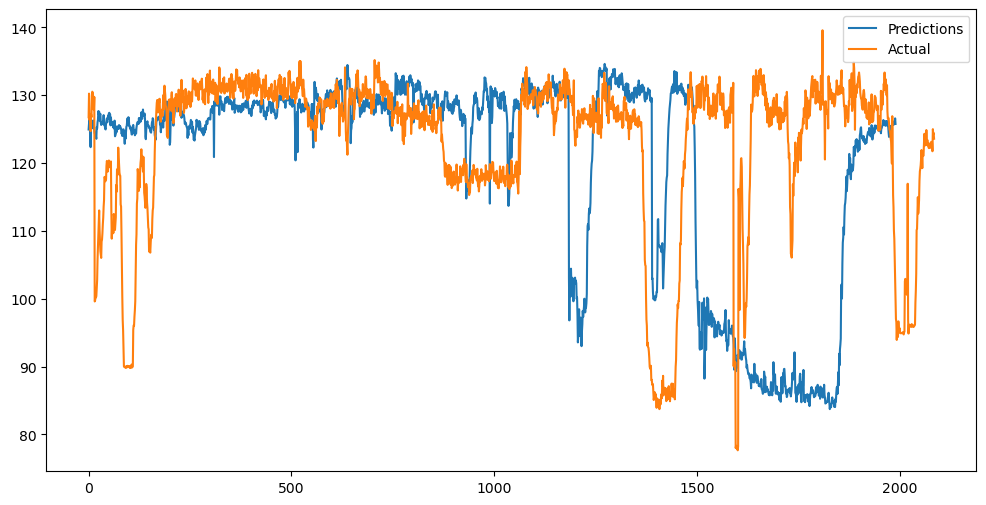

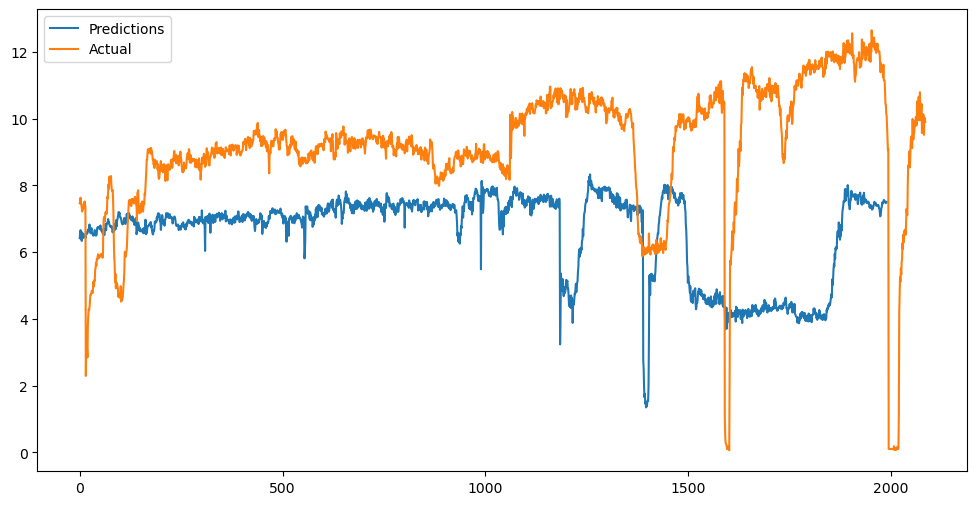

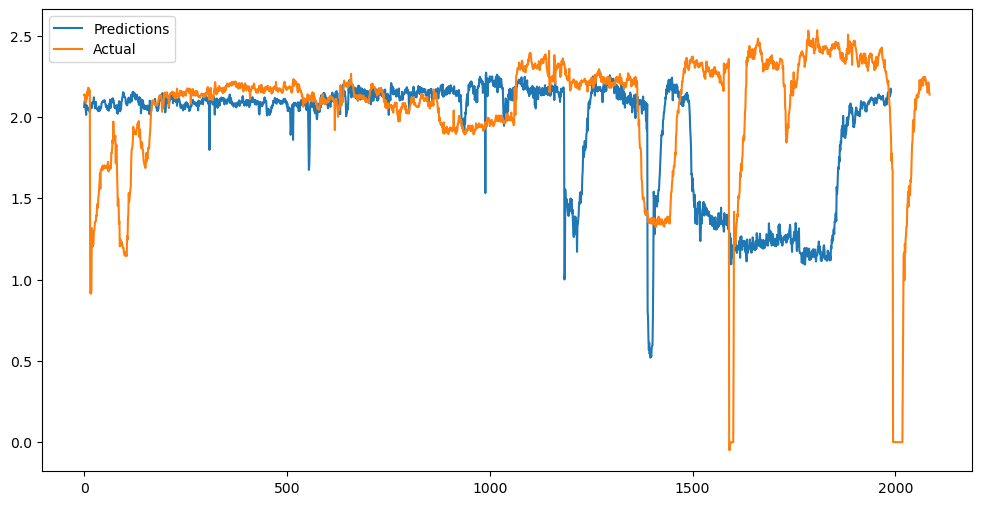

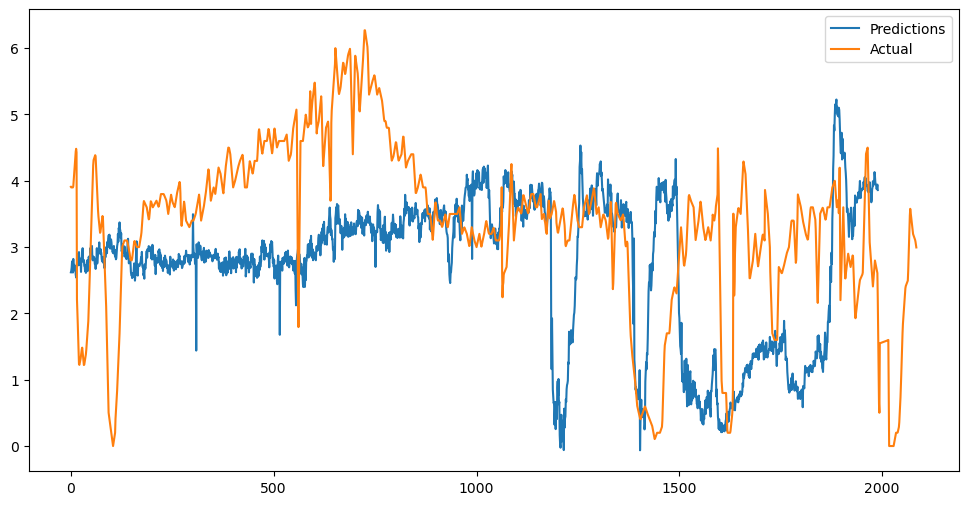

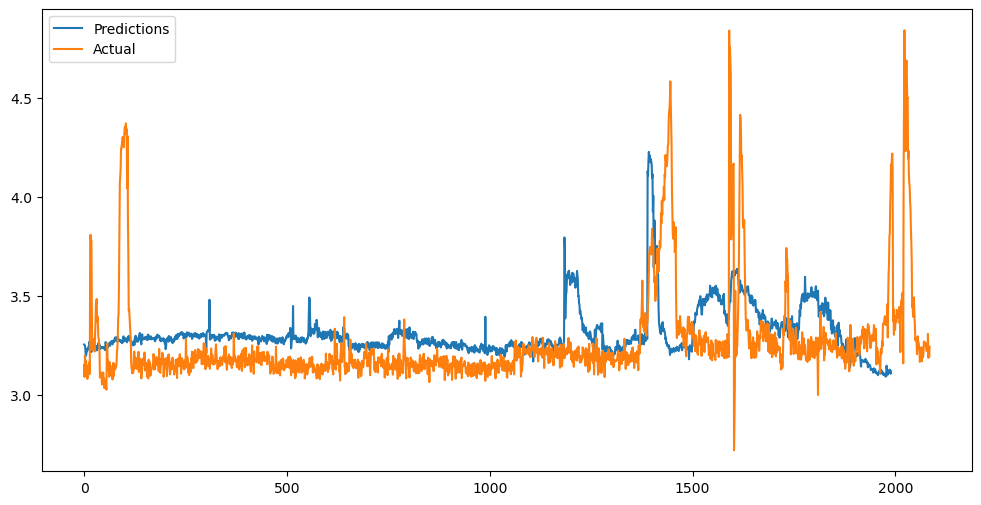

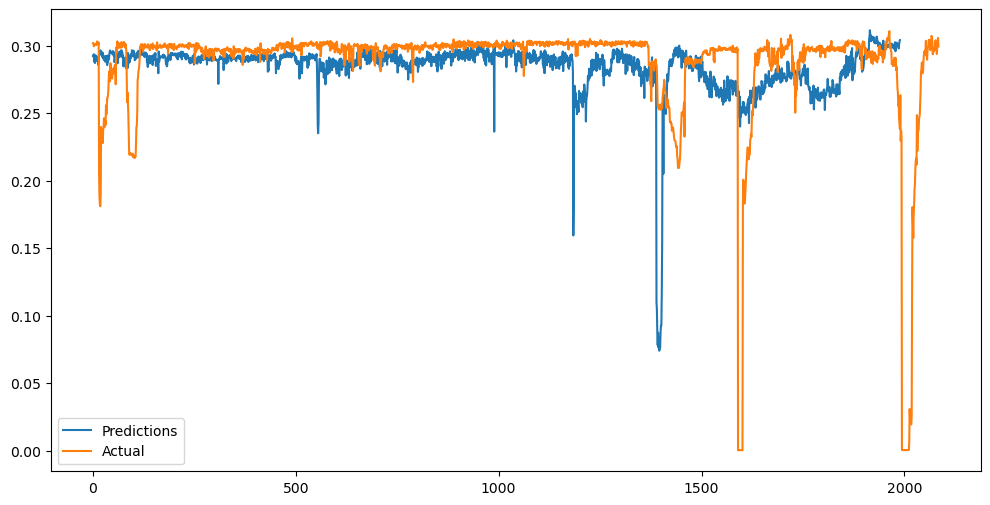

IndexError: index 45 is out of bounds for axis 1 with size 45

<Figure size 1200x600 with 0 Axes>

In [26]:
import matplotlib.pyplot as plt
# Iterate over each feature
for i in range(1990):
    plt.figure(figsize=(12, 6))
    
    # Plot the predicted data
    plt.plot(predictions[:, i], label='Predictions')
    
    # Plot the actual test data
    plt.plot(test_array_np[:, i], label='Actual')
    
    
    plt.legend()
    plt.show()

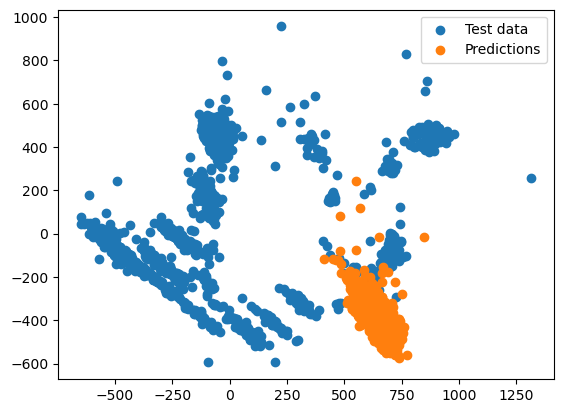

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert pandas DataFrame to numpy array
test_array_np = test_data.values

# Get non-overlapping predictions


# Run PCA on test data and predictions
pca = PCA(n_components=2)
test_pca = pca.fit_transform(test_array_np)
predictions_pca = pca.transform(predictions)

# Plot test data
plt.scatter(test_pca[:, 0], test_pca[:, 1], label='Test data')

# Plot prediction data
plt.scatter(predictions_pca[:, 0], predictions_pca[:, 1], label='Predictions')

plt.legend()
plt.show()


C:\Users\16148\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\16148\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\16148\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\16148\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


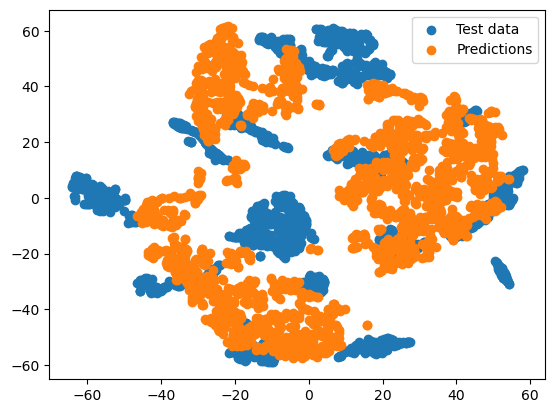

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert pandas DataFrame to numpy array
test_array_np = test_data.values

# Get non-overlapping predictions


# Run t-SNE on test data and predictions
tsne = TSNE(n_components=2, random_state=0)
test_tsne = tsne.fit_transform(test_array_np)
predictions_tsne = tsne.fit_transform(predictions)

# Plot test data
plt.scatter(test_tsne[:, 0], test_tsne[:, 1], label='Test data')

# Plot prediction data
plt.scatter(predictions_tsne[:, 0], predictions_tsne[:, 1], label='Predictions')

plt.legend()
plt.show()
